## Installation and Import

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (153 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145655 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Dataset generation

### Customize data generator
Create a generator that can generate patches from different levels together

In [0]:
# Create a generator that can generate patches from different levels together
def generator_together(dir1, dir2, batch_size, input_size, seed, generator):
  gen1 = generator.flow_from_directory(
      dir1,
      batch_size=batch_size,
      target_size=input_size,
      seed=seed,
      class_mode='binary'
  )
  gen2 = generator.flow_from_directory(
      dir2,
      batch_size=batch_size,
      target_size=input_size,
      seed=seed,
      class_mode='binary'
  )
  while True:
    d1 = gen1.next()
    d2 = gen2.next()
    yield [d1[0], d2[0]], d1[1]


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 1
train_datagen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip = True,
                               rescale=1./255,
                               width_shift_range=(-8, 8),
                               height_shift_range=(-8, 8),
                               rotation_range = 90,
                               brightness = 64/255)
#train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_level2_dir = '/content/drive/My Drive/adl_project/train/level_2'
train_level3_dir = '/content/drive/My Drive/adl_project/train/level_3'
val_level2_dir = '/content/drive/My Drive/adl_project/val/level_2'
val_level3_dir = '/content/drive/My Drive/adl_project/val/level_3'

train_generator = generator_together(train_level2_dir, train_level3_dir, 32, (299,299), seed, train_datagen)
val_generator = generator_together(val_level2_dir, val_level3_dir, 32, (299,299), seed, val_datagen)

### Check data generator
Check the data generator to see if it works correctly

In [0]:
for x, y in train_generator:
  break

Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


The number of patches in training set is correct.

In [0]:
for x, y in val_generator:
  break

Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


The number of patches in test set is correct.

0.0


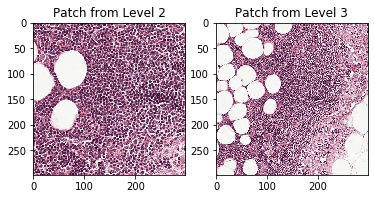

In [0]:
# Check if the patches are of the same center
for x, y in val_generator:
  plt.subplot(1,2,1)
  plt.imshow(x[0][0])
  plt.title('Patch from Level 2')
  plt.subplot(1,2,2)
  plt.imshow(x[1][0])
  plt.title('Patch from Level 3')
  print(y[0])
  break

From the picture, we can see that the patches are of the same center

## Model

### Model with single scale input (not use)
This model structure is not the final structure. 

In [0]:
# Model Structure with single scale input
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, RMSprop
NB_IV3_LAYERS_TO_FREEZE = 295
model = tf.keras.Sequential()
base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(299,299,3))
for layer in base_model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
  layer.trainable = False
#base_model.trainable = False
model.add(base_model)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = RMSprop()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 22,327,585
Trainable params: 920,065
Non-trainable params: 21,407,520
_________________________________________________________________


### Ensemble model with multi scale input
I use two fine-tuning Inception towers as the base model. Then I concatenate the results of the two Inception towers and then calculate the final result.

In [0]:
# Model structure with multi-scale input
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.layers import Dense, concatenate, Input, Dropout
from tensorflow.keras.models import Sequential, Model
def create_model():
  # Base model using Inception tower
  inception_level1 = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',
                            include_top=False,
                            pooling='avg',
                            input_shape=(299,299,3))
  
  inception_level2 = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',
                            include_top=False,
                            pooling='avg',
                            input_shape=(299,299,3))
  
  # Freeze first 295 layers and use fine-tuning
  for layer in inception_level1.layers[:295]:
    layer.trainable = False
  for layer in inception_level2.layers[:295]:
    layer.trainable = False

  # Transfer learning
  #inception_level1.trainable = False
  #inception_level2.trainable = False
  
  base_level1 = Sequential()
  base_level1.add(inception_level1)
  base_level2 = Sequential()
  base_level2.add(inception_level2)

  input_level1 = Input(shape=(299, 299, 3))
  input_level2 = Input(shape=(299, 299, 3))

  logits_level1 = base_level1(input_level1)
  logits_level2 = base_level2(input_level2)

  merged = concatenate([logits_level1, logits_level2])
  dense = Dense(256, activation='relu')(merged)
  output = Dense(1, activation='sigmoid')(dense)
  model = Model(inputs=[input_level1, input_level2], outputs=output)

  return model

In [0]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 2048)         21802784    input_11[0][0]                   
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 2048)         21802784    input_12[0][0]                   
____________________________________________________________________________________________

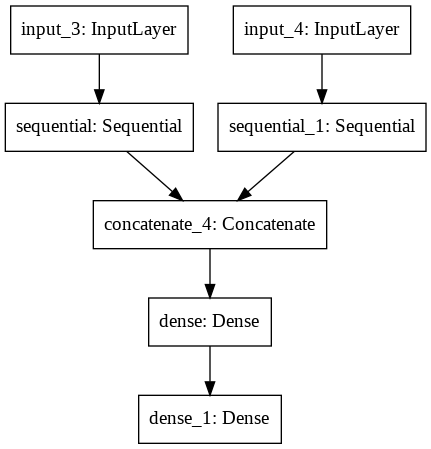

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
# Create checkpoint to save the model
root = '/content/drive/My Drive/adl_project'
checkpoint_dir = os.path.join(root, "model")
checkpoint_path = os.path.join(checkpoint_dir, "ensemble_model-{epoch:06d}.h5")
callbacks = [
             tf.keras.callbacks.ModelCheckpoint(
                 filepath=checkpoint_path,
                 monitor='val_loss',
                 verbose=1),
             tf.keras.callbacks.ReduceLROnPlateau(
                 monitor='loss', 
                 factor=0.2,
                 patience=5, 
                 min_lr=0.0001)
]
opt = RMSprop()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model training

In [0]:
# Train the model
history = model.fit_generator(
      train_generator,
      epochs=20,
      callbacks = callbacks,
      validation_data=val_generator,
      steps_per_epoch=6000/32,
      validation_steps=600/32)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 187.5 steps, validate for 18.75 steps
Epoch 1/20
187/187 [============================>.] - ETA: 11s - loss: 0.5838 - accuracy: 0.8484
Epoch 00001: saving model to /content/drive/My Drive/adl_project/model/ensemble_model-0000001.h5
188/187 [==============================] - 4263s 23s/step - loss: 0.5815 - accuracy: 0.8490 - val_loss: 2.4859 - val_accuracy: 0.6650
Epoch 2/20
187/187 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9092
Epoch 00002: saving model to /content/drive/My Drive/adl_project/model/ensemble_model-0000002.h5
188/187 [==============================] - 263s 1s/step - loss: 0.2279 - accuracy: 0.9093 - val_loss: 3.8217 - val_accuracy: 0.6567
Epoch 3/20
187/187 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9219
Epoch 00003: saving model to /content/drive/My Drive/adl_project/model/ensemb

# Test Result

### Extract test patches

In [0]:
# Necessary functions
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
    
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

def set_mask(im, mask):
  masked = np.zeros((im.shape[0], im.shape[1]))
  for x,y in mask: masked[x][y] = 1
  return masked

In [0]:
# extract patches from test slide of different zoom levels together
def get_test_patches(slide_1, slide_2, mask, patch_size, stride):
  height, width = slide_1.shape[0], slide_1.shape[1]
  # Coordinate of the left top point of a patch
  range_y = np.arange(0,height - patch_size[0], stride)
  range_x = np.arange(0,width - patch_size[1], stride)
  patches_1 = []
  patches_2 = []
  true_labels = []
  for y in range_y:
    for x in range_x:
      patches_1.append(slide_1[y:y + patch_size[0], x:x + patch_size[1]]/255)
      # Calculate the center of the patch
      # Use the center to get the patch of different level
      center = [y + patch_size[0] // 2, x + patch_size[1] // 2]
      left_top = [y + patch_size[0] // 2 - stride // 2, x + patch_size[1] // 2 - stride // 2]
      patch_mask = mask[left_top[0]:left_top[0] + stride, left_top[1]:left_top[1] + stride]
      patch_2 = np.zeros((patch_size[0], patch_size[1], 3), dtype=np.uint8)
      # If the patch of the lower resolution is out of range, use 0 to pad
      lt = [max(0, (center[0]-patch_size[0])//2), max(0, center[1]//2-patch_size[1]//2)]
      rb = [min(slide_2.shape[0], center[0]//2+patch_size[0]//2), min(slide_2.shape[1], center[1]//2+patch_size[1]//2)]
      patch_lt = [max(0, (patch_size[0]-center[0])//2), max(0, patch_size[1]//2-center[1]//2)]
      patch_rb = [patch_lt[0] + rb[0] - lt[0], patch_lt[1] + rb[1] - lt[1]]
      patch_2[patch_lt[0]:patch_rb[0], patch_lt[1]:patch_rb[1]] = slide_2[lt[0]:rb[0],lt[1]:rb[1]]
      patches_2.append(patch_2/255)
      # If no pixel in this patch is tumor, it will be a normal patch
      # Otherwise, it is tumor patch
      if np.sum(patch_mask) == 0:
        true_labels.append(0)
      else:
        true_labels.append(1)
      
  return patches_1, patches_2, true_labels

### Calculate metrics

In [0]:
def precision_recall(true_y, pred, threshold):
  tp, tn, fp, fn = 0, 0, 0, 0
  for i in range(len(true_y)):
    if true_y[i] == 1:
      if pred[i] < threshold:
        fn += 1.0
      else:
        tp += 1.0
    else:
      if pred[i] < threshold:
        tn += 1.0
      else:
        fp += 1.0
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)
  return precision, recall, f1

### Load model

In [0]:
# I use the model that has the smallest validation loss 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/adl_project/model/ensemble_model-0000014.h5')

### Result of slide test_001

In [0]:
# Read slide and mask of test_001.tif
slide_path = '/content/drive/My Drive/adl_project/test/test_001.tif'
mask_path = '/content/drive/My Drive/adl_project/test/test_001_mask.tif'
slide = open_slide(slide_path)
slide_1 = read_slide(slide, x=0, y=0, level=2,
                  width=slide.level_dimensions[2][0],
                  height=slide.level_dimensions[2][1])
slide_2 = read_slide(slide, x=0, y=0, level=3,
                  width=slide.level_dimensions[3][0],
                  height=slide.level_dimensions[3][1])
mask = open_slide(mask_path)
mask_1 = read_slide(mask, x=0, y=0, level=2,
                  width=mask.level_dimensions[2][0],
                  height=mask.level_dimensions[2][1])

In [0]:
# Extract patches
patches_1, patches_2, true_labels_1 = get_test_patches(slide_1, slide_2, mask_1[:,:,0], [299, 299], 128)

In [0]:
# Calculate prediction of test set
total_number = len(patches_1)
step = total_number // 32
prediction_1 = np.zeros(total_number, dtype=np.float32)
for i in range(step):
  if i == step - 1:
    batch_1 = tf.convert_to_tensor(patches_1[i*32:total_number], np.float32)
    batch_2 = tf.convert_to_tensor(patches_2[i*32:total_number], np.float32)
    prediction_1[i*32:total_number] = model.predict([batch_1, batch_2])[:,0]
  else:
    batch_1 = tf.convert_to_tensor(patches_1[i*32:i*32+32], np.float32)
    batch_2 = tf.convert_to_tensor(patches_2[i*32:i*32+32], np.float32)
    prediction_1[i*32:i*32+32] = model.predict([batch_1, batch_2])[:,0]

(-0.5, 165.5, 172.5, -0.5)

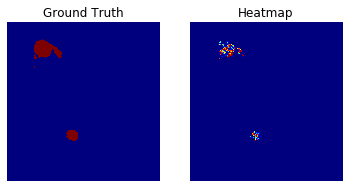

In [0]:
height, width = slide.level_dimensions[2][1], slide.level_dimensions[2][0]
range_y = np.arange(0,height - 299, 128)
range_x = np.arange(0,width - 299, 128)
# Reshape the prediction and true_labels to the picture shape
heatmap = np.array(prediction_1).reshape((len(range_y), len(range_x)))
#heatmap = prediction_1
truth = np.array(true_labels_1).reshape((len(range_y), len(range_x)))
plt.subplot(1,2,1)
plt.imshow(truth, cmap='jet')
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='jet')
plt.title('Heatmap')
plt.axis('off')

In [0]:
slide_1 = slide_1[80:slide_1.shape[0]-176, 80:slide_1.shape[1]-176]
# Recover the heatmap and ground truth of tumor label to the slide size
new_heat = np.zeros((len(range_y)*128, len(range_x)*128))
for i in range(len(range_y)):
  for j in range(len(range_x)):
    new_heat[i*128:i*128+128,j*128:j*128+128] = heatmap[i,j]
new_truth = np.zeros((len(range_y)*128, len(range_x)*128))
for i in range(len(range_y)):
  for j in range(len(range_x)):
    new_truth[i*128:i*128+128,j*128:j*128+128] = truth[i,j]

(-0.5, 21247.5, 22143.5, -0.5)

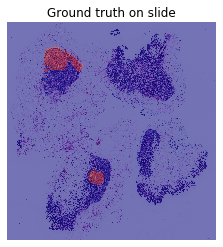

In [0]:
plt.imshow(slide_1)
plt.imshow(new_truth, cmap='jet', alpha=0.5)
plt.title('Ground truth on slide')
plt.axis('off')

(-0.5, 21247.5, 22143.5, -0.5)

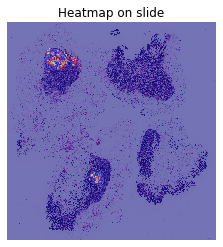

In [0]:
plt.imshow(slide_1)
plt.imshow(new_heat, cmap='jet', alpha=0.5)
plt.title('Heatmap on slide')
plt.axis('off')

In [0]:
from sklearn.metrics import roc_auc_score, precision_recall_curve
auc = roc_auc_score(true_labels_1, prediction_1)
precision, recall, f1 = precision_recall(true_labels_1, prediction_1, 0.0006)
print('The auc of slide test_001 is {}.'.format(auc))
print('The recall of the slide test_001 is {}.'.format(recall))
print('The F1 score of the slide test_001 is {}.'.format(f1))

The auc of slide test_001 is 0.9331583536695987.
The recall of the slide test_001 is 0.8.
The F1 score of the slide test_001 is 0.6726530612244899.


### Result of slide test_079

In [0]:
# Read slide and mask of test_040.tif
slide_path = '/content/drive/My Drive/adl_project/test/test_079.tif'
mask_path = '/content/drive/My Drive/adl_project/test/test_079_mask.tif'
slide = open_slide(slide_path)
slide_1 = read_slide(slide, x=0, y=0, level=2,
                  width=slide.level_dimensions[2][0],
                  height=slide.level_dimensions[2][1])
slide_2 = read_slide(slide, x=0, y=0, level=3,
                  width=slide.level_dimensions[3][0],
                  height=slide.level_dimensions[3][1])
mask = open_slide(mask_path)
mask_1 = read_slide(mask, x=0, y=0, level=2,
                  width=mask.level_dimensions[2][0],
                  height=mask.level_dimensions[2][1])

In [0]:
patches_1, patches_2, true_labels_2 = get_test_patches(slide_1, slide_2, mask_1[:,:,0], [299, 299], 128)

In [0]:
total_number = len(patches_1)
step = total_number // 32
prediction_2 = np.zeros(total_number, dtype=np.float32)
for i in range(step):
  if i % 100 == 99:
    print('Step {} complete'.format(i+1))
  if i == step - 1:
    batch_1 = tf.convert_to_tensor(patches_1[i*32:total_number], np.float32)
    batch_2 = tf.convert_to_tensor(patches_2[i*32:total_number], np.float32)
    prediction_2[i*32:total_number] = model.predict([batch_1, batch_2])[:,0]
  else:
    batch_1 = tf.convert_to_tensor(patches_1[i*32:i*32+32], np.float32)
    batch_2 = tf.convert_to_tensor(patches_2[i*32:i*32+32], np.float32)
    prediction_2[i*32:i*32+32] = model.predict([batch_1, batch_2])[:,0]

(-0.5, 197.5, 165.5, -0.5)

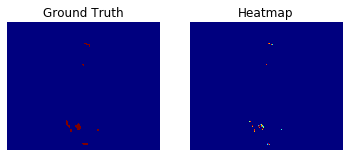

In [0]:
height, width = slide.level_dimensions[2][1], slide.level_dimensions[2][0]
range_y = np.arange(0,height - 299, 128)
range_x = np.arange(0,width - 299, 128)
# Reshape the prediction and true_labels to the picture shape
heatmap = np.array(prediction_2).reshape((len(range_y), len(range_x)))
#heatmap = prediction_1
truth = np.array(true_labels_2).reshape((len(range_y), len(range_x)))
plt.subplot(1,2,1)
plt.imshow(truth, cmap='jet')
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='jet')
plt.title('Heatmap')
plt.axis('off')

In [0]:
slide_1 = slide_1[80:slide_1.shape[0]-176, 80:slide_1.shape[1]-176]
# Recover the heatmap and ground truth of tumor label to the slide size
new_heat = np.zeros((len(range_y)*128, len(range_x)*128))
for i in range(len(range_y)):
  for j in range(len(range_x)):
    new_heat[i*128:i*128+128,j*128:j*128+128] = heatmap[i,j]
new_truth = np.zeros((len(range_y)*128, len(range_x)*128))
for i in range(len(range_y)):
  for j in range(len(range_x)):
    new_truth[i*128:i*128+128,j*128:j*128+128] = truth[i,j]

(-0.5, 25343.5, 21247.5, -0.5)

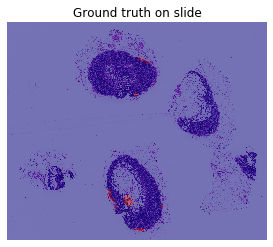

In [0]:
plt.imshow(slide_1)
plt.imshow(new_truth, cmap='jet', alpha=0.5)
plt.title('Ground truth on slide')
plt.axis('off')

(-0.5, 25343.5, 21247.5, -0.5)

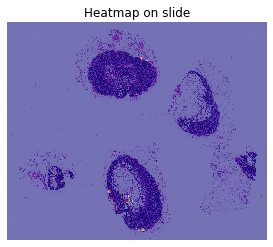

In [0]:
plt.imshow(slide_1)
plt.imshow(new_heat, cmap='jet', alpha=0.5)
plt.title('Heatmap on slide')
plt.axis('off')

In [0]:
from sklearn.metrics import roc_auc_score, precision_recall_curve
auc = roc_auc_score(true_labels_2, prediction_2)
precision, recall, f1 = precision_recall(true_labels_2, prediction_2, 0.0006)
print('The auc of slide test_079 is {}.'.format(auc))
print('The recall of the slide test_079 is {}.'.format(recall))
print('The f1 of the slide test_079 is {}.'.format(f1))

The auc of slide test_079 is 0.9516129032258065.
The recall of the slide test_079 is 0.4435483870967742.
The f1 of the slide test_079 is 0.6145251396648045.


### Result of slide test_094

In [0]:
# Read slide and mask of test_094.tif
slide_path = '/content/drive/My Drive/adl_project/test/test_094.tif'
mask_path = '/content/drive/My Drive/adl_project/test/test_094_mask.tif'
slide = open_slide(slide_path)
slide_1 = read_slide(slide, x=0, y=0, level=2,
                  width=slide.level_dimensions[2][0],
                  height=slide.level_dimensions[2][1])
slide_2 = read_slide(slide, x=0, y=0, level=3,
                  width=slide.level_dimensions[3][0],
                  height=slide.level_dimensions[3][1])
mask = open_slide(mask_path)
mask_1 = read_slide(mask, x=0, y=0, level=2,
                  width=mask.level_dimensions[2][0],
                  height=mask.level_dimensions[2][1])

In [0]:
patches_1, patches_2, true_labels_3 = get_test_patches(slide_1, slide_2, mask_1[:,:,0], [299, 299], 128)

In [0]:
total_number = len(patches_1)
step = total_number // 32
prediction_3 = np.zeros(total_number, dtype=np.float32)
for i in range(step):
  if i % 100 == 99:
    print('Step {} complete'.format(i+1))
  if i == step - 1:
    batch_1 = tf.convert_to_tensor(patches_1[i*32:total_number], np.float32)
    batch_2 = tf.convert_to_tensor(patches_2[i*32:total_number], np.float32)
    prediction_2[i*32:total_number] = model.predict([batch_1, batch_2])[:,0]
  else:
    batch_1 = tf.convert_to_tensor(patches_1[i*32:i*32+32], np.float32)
    batch_2 = tf.convert_to_tensor(patches_2[i*32:i*32+32], np.float32)
    prediction_3[i*32:i*32+32] = model.predict([batch_1, batch_2])[:,0]

(-0.5, 181.5, 158.5, -0.5)

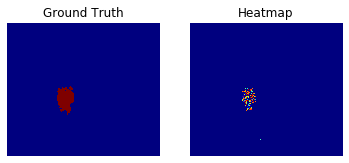

In [0]:
height, width = slide.level_dimensions[2][1], slide.level_dimensions[2][0]
range_y = np.arange(0,height - 299, 128)
range_x = np.arange(0,width - 299, 128)
# Reshape the prediction and true_labels to the picture shape
heatmap = np.array(prediction_3).reshape((len(range_y), len(range_x)))
#heatmap = prediction_1
truth = np.array(true_labels_3).reshape((len(range_y), len(range_x)))
plt.subplot(1,2,1)
plt.imshow(truth, cmap='jet')
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='jet')
plt.title('Heatmap')
plt.axis('off')

In [0]:
slide_1 = slide_1[80:slide_1.shape[0]-176, 80:slide_1.shape[1]-176]
# Recover the heatmap and ground truth of tumor label to the slide size
new_heat = np.zeros((len(range_y)*128, len(range_x)*128))
for i in range(len(range_y)):
  for j in range(len(range_x)):
    new_heat[i*128:i*128+128,j*128:j*128+128] = heatmap[i,j]
new_truth = np.zeros((len(range_y)*128, len(range_x)*128))
for i in range(len(range_y)):
  for j in range(len(range_x)):
    new_truth[i*128:i*128+128,j*128:j*128+128] = truth[i,j]

(-0.5, 23295.5, 20351.5, -0.5)

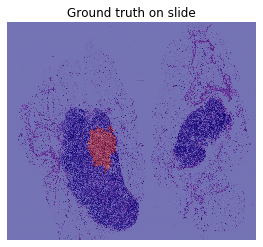

In [0]:
plt.imshow(slide_1)
plt.imshow(new_truth, cmap='jet', alpha=0.5)
plt.title('Ground truth on slide')
plt.axis('off')

(-0.5, 23295.5, 20351.5, -0.5)

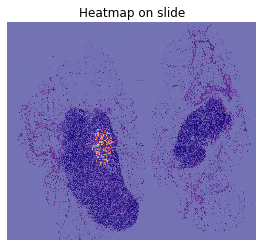

In [0]:
plt.imshow(slide_1)
plt.imshow(new_heat, cmap='jet', alpha=0.5)
plt.title('Heatmap on slide')
plt.axis('off')

In [0]:
from sklearn.metrics import roc_auc_score, precision_recall_curve
auc = roc_auc_score(true_labels_3, prediction_3)
precision, recall, f1 = precision_recall(true_labels_3, prediction_3, 0.0006)
print('The auc of slide test_094 is {}.'.format(auc))
print('The recall of the slide test_094 is {}.'.format(recall))
print('The f1 of the slide test_094 is {}.'.format(f1))

The auc of slide test_094 is 0.9111945324008303.
The recall of the slide test_094 is 0.5932203389830508.
The f1 of the slide test_094 is 0.7358738501971092.


### Total result

In [0]:
prediction = np.append(prediction_1, prediction_2)
prediction = np.append(prediction, prediction_3)
true_labels = np.append(true_labels_1, true_labels_2)
true_labels = np.append(true_labels, true_labels_3)
auc = roc_auc_score(true_labels, prediction)
precision, recall, f1 = precision_recall(true_labels, prediction, 0.0006)
print('The auc of test set is {}.'.format(auc))
print('The recall of test set is {}.'.format(recall))
print('The f1 of the test set is {}.'.format(f1))

The auc of test set is 0.9317040485769357.
The recall of test set is 0.6723672367236724.
The f1 of the test set is 0.6900692840646652.
